In [1]:
import matplotlib.pyplot as plt

import pandas as pd

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.print_version import show_versions
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [2]:
show_versions()


INSTALLED VERSIONS
------------------
Python: 3.10.13.final.0
OS: Darwin 23.2.0 Darwin Kernel Version 23.2.0: Wed Nov 15 21:53:18 PST 2023; root:xnu-10002.61.3~2/RELEASE_ARM64_T6000 arm64
byteorder: little
LC_ALL: None
LANG: None

statsmodels

Installed: 0.14.1 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/statsmodels)

Required Dependencies

cython: Not installed
numpy: 1.26.3 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/numpy)
scipy: 1.11.4 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/scipy)
pandas: 2.1.4 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/pandas)
    dateutil: 2.8.2 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/dateutil)
patsy: 0.5.6 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/patsy)

Optional Dependencies

matplotlib: 3.8.0 (/opt/homebrew/Caskroom/miniconda/ba

In [3]:
returns = pd.read_csv('returns.txt', header=None).squeeze()
returns.index = pd.date_range('1/1/2000', periods=returns.values.shape[0], freq='D')
returns.name = 'returns'

returns.head()

2000-01-01   -0.000085
2000-01-02    0.000093
2000-01-03    0.000026
2000-01-04    0.000034
2000-01-05   -0.000077
Freq: D, Name: returns, dtype: float64

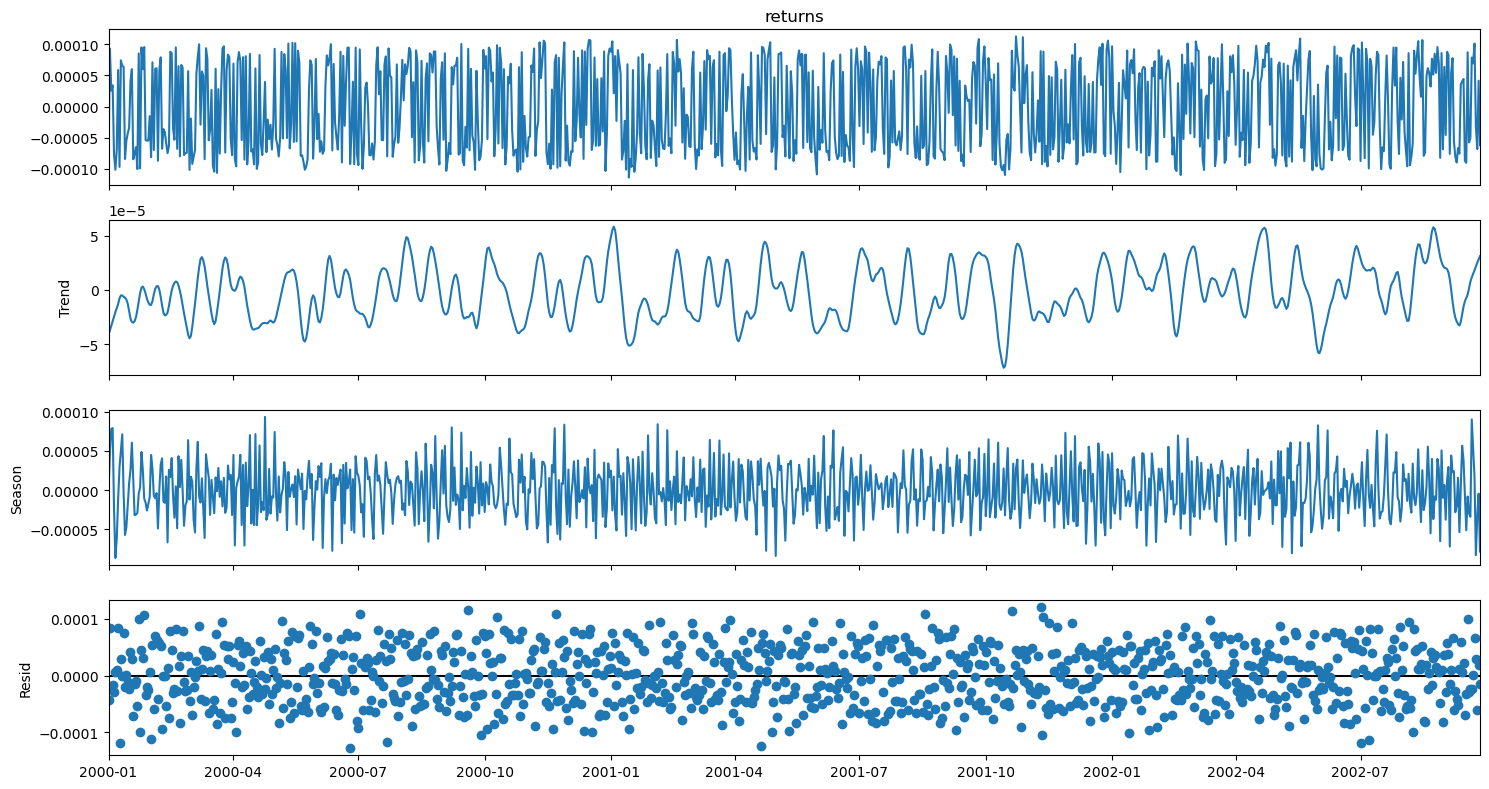

In [4]:
plt.rcParams['figure.figsize'] = (15, 8)

res = STL(returns).fit()
res.plot();

ADF Statistic: -7.110292
p-value: 0.000000
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599


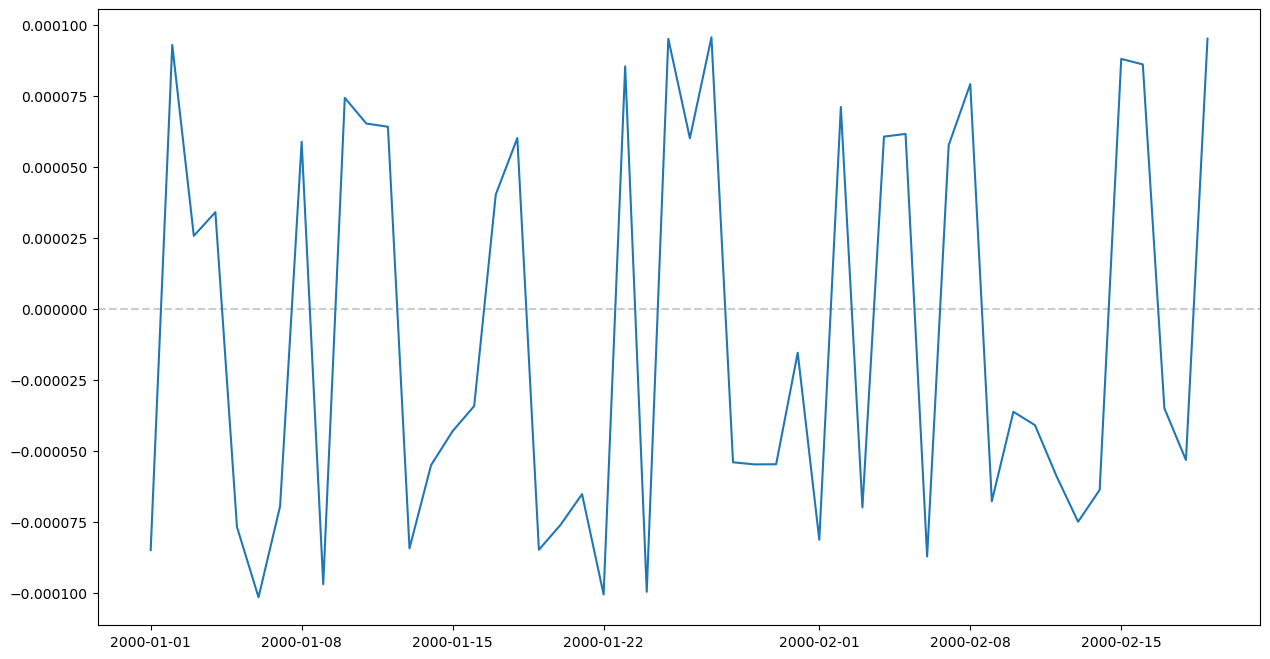

In [5]:
def adfuller_test_and_plot(series, first_50=True):
    len = 50 if first_50 else series.values.shape[0]
    slice = series[:len]

    adf = adfuller(slice)
    print('ADF Statistic: %f' % adf[0])
    print('p-value: %f' % adf[1])
    print('Critical Values:')
    for key, value in adf[4].items():
        print('\t%s: %.3f' % (key, value))

    plt.axhline(0, color='k', linestyle='--', alpha=0.2)
    plt.plot(slice)

adfuller_test_and_plot(returns)

ADF Statistic: -7.110292
p-value: 0.000000
Critical Values:
	1%: -3.571
	5%: -2.923
	10%: -2.599


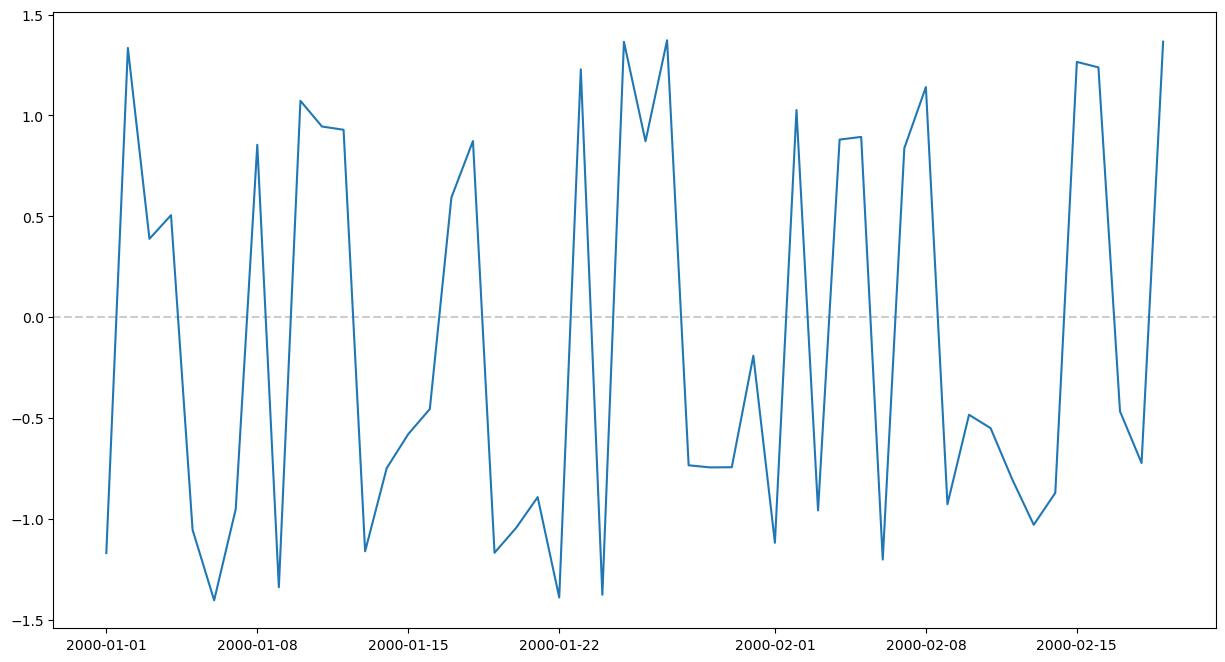

In [6]:
mu = returns.mean()
sigma = returns.std()

norm_returns = (returns - mu) / sigma

adfuller_test_and_plot(norm_returns)

ADF Statistic: -6.080469
p-value: 0.000000
Critical Values:
	1%: -3.593
	5%: -2.932
	10%: -2.604


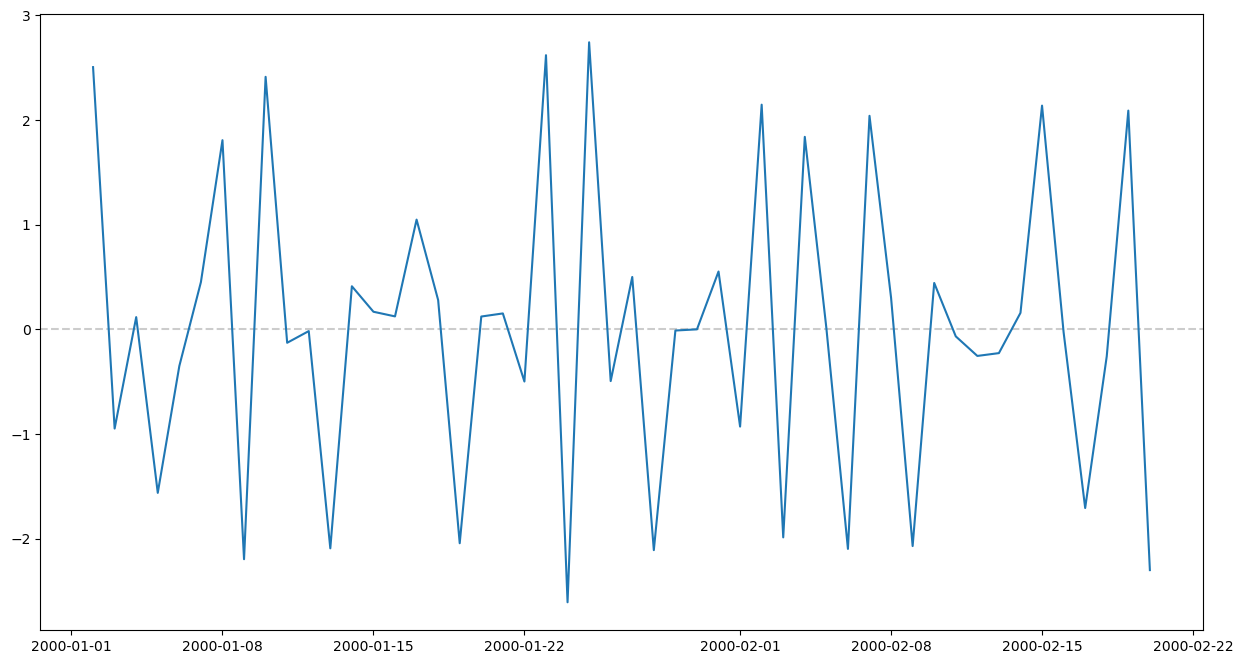

In [7]:
diff_returns = norm_returns.diff().dropna()

adfuller_test_and_plot(diff_returns)

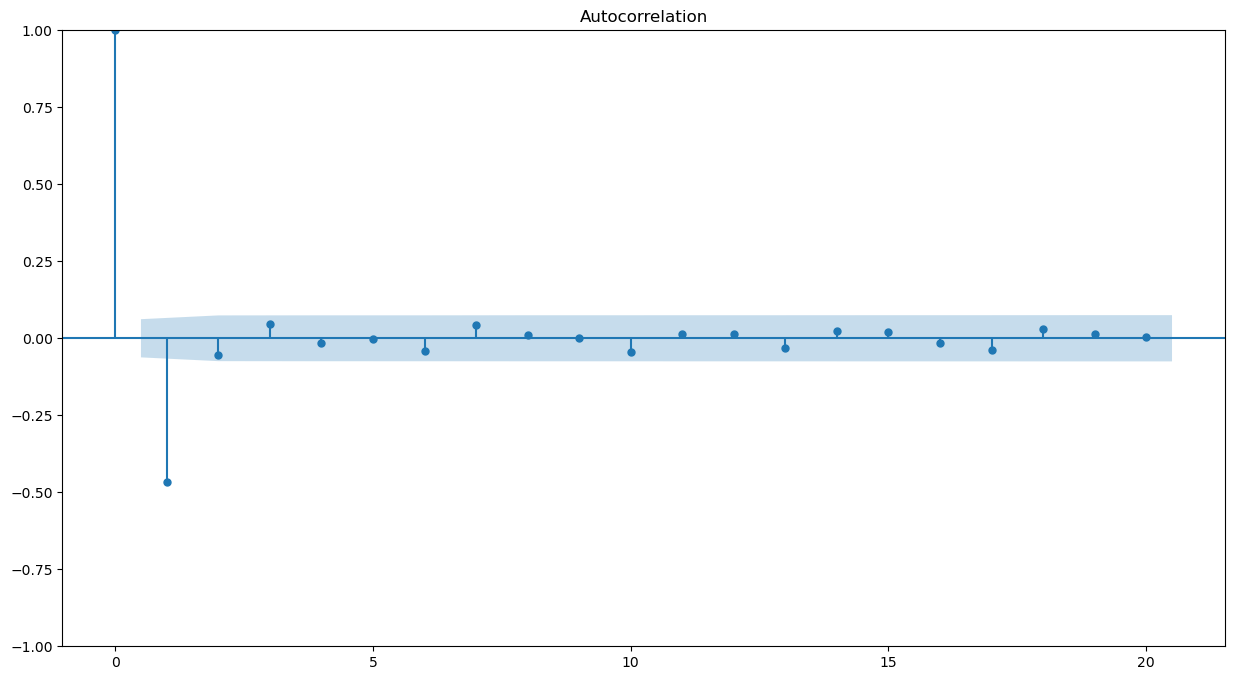

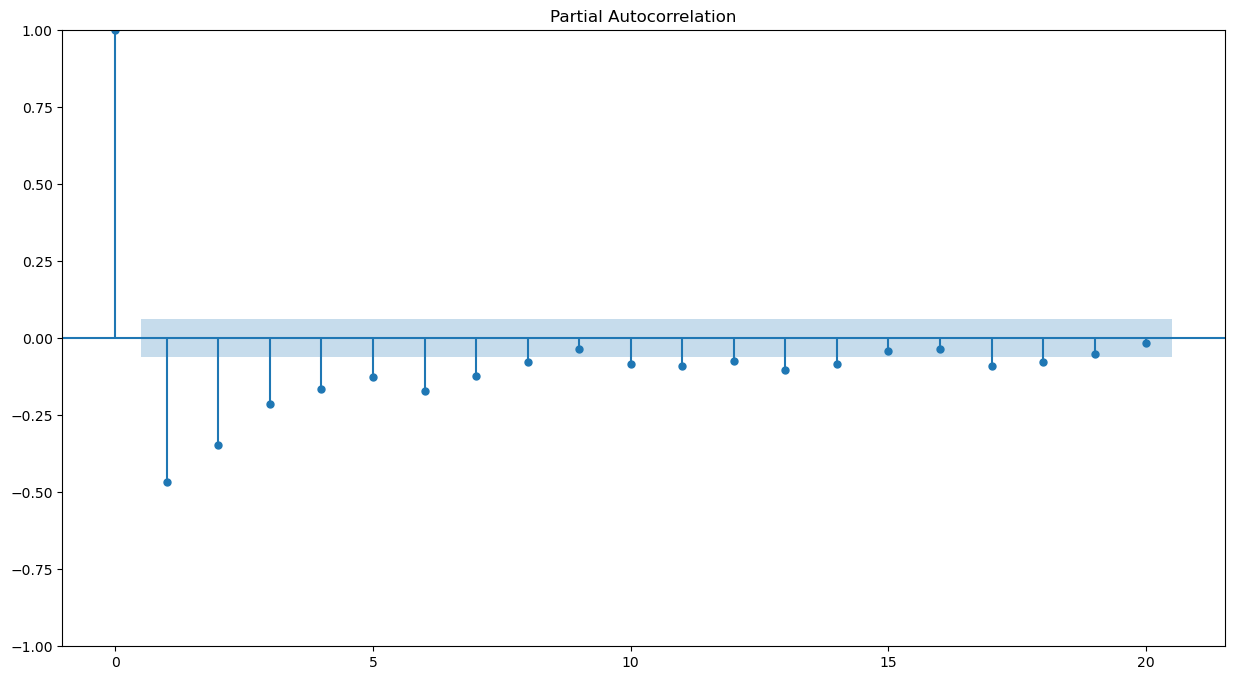

In [8]:
plot_acf(diff_returns, lags=20);
plot_pacf(diff_returns, lags=20);

                               SARIMAX Results                                
Dep. Variable:                returns   No. Observations:                  500
Model:                ARIMA(20, 1, 1)   Log Likelihood                -674.901
Date:                Thu, 18 Jan 2024   AIC                           1393.802
Time:                        12:42:19   BIC                           1485.579
Sample:                    01-01-2000   HQIC                          1429.881
                         - 05-14-2001                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0120      0.047      0.255      0.799      -0.080       0.104
ar.L2          0.0329      0.047      0.694      0.488      -0.060       0.126
ar.L3          0.0426      0.047      0.905      0.3

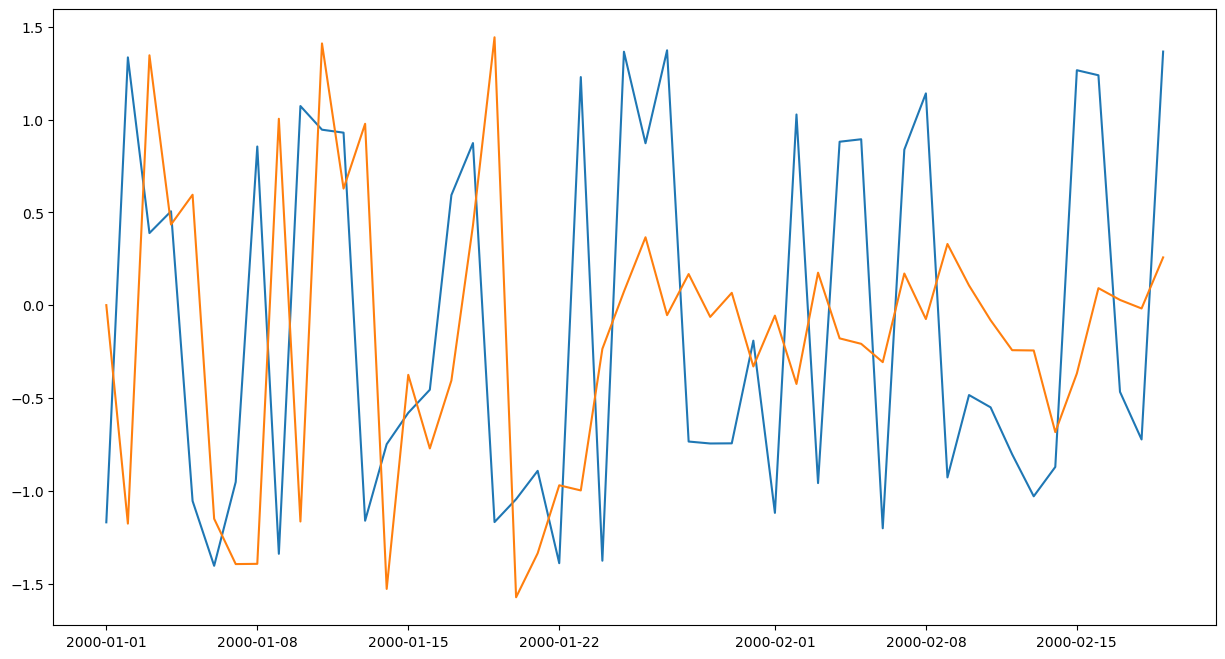

In [9]:
train_data = norm_returns[:500]
test_data = norm_returns[500:]

model = ARIMA(train_data, order=(20, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit()

print(model_fit.summary())

plt.plot(norm_returns[:50])
plt.plot(model_fit.fittedvalues[:50])

                                      SARIMAX Results                                      
Dep. Variable:                             returns   No. Observations:                  500
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 7)   Log Likelihood                -877.808
Date:                             Thu, 18 Jan 2024   AIC                           1761.617
Time:                                     12:42:19   BIC                           1774.255
Sample:                                 01-01-2000   HQIC                          1766.576
                                      - 05-14-2001                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.1877      0.985      0.190      0.849      -1.744       2.119
ma.S.L7       -0.1409      

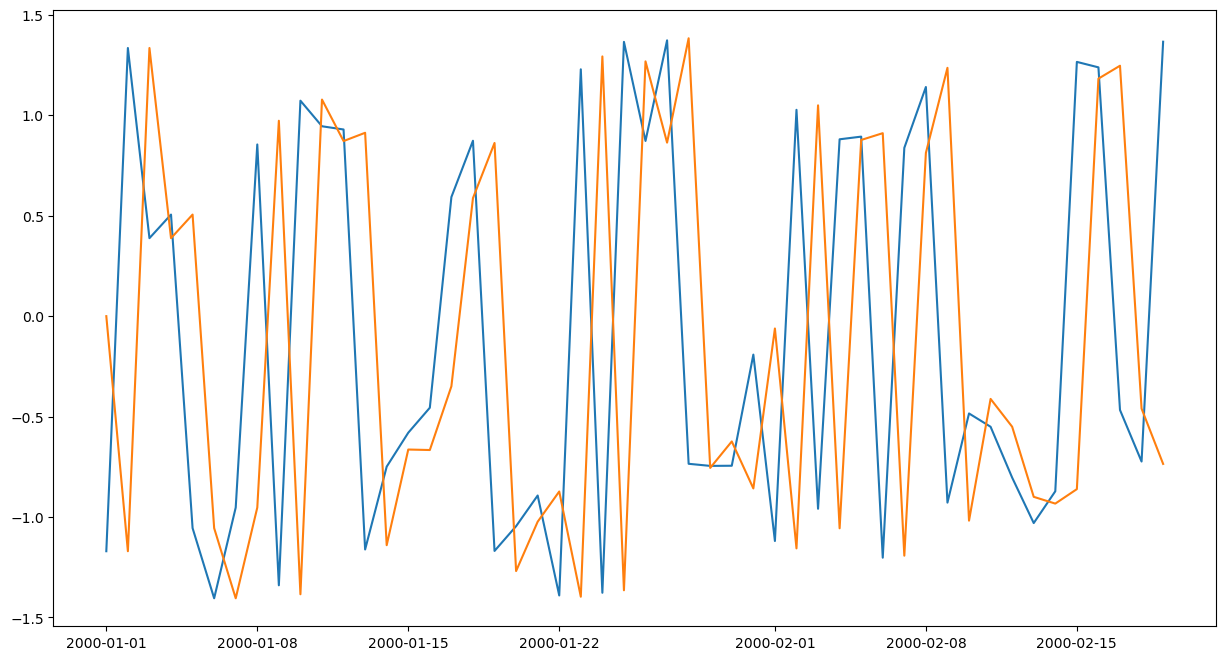

In [10]:
model = SARIMAX(train_data, order=(0, 1, 0), seasonal_order=(1, 0, 1, 7))
model_fit = model.fit(disp=0)

print(model_fit.summary())

plt.plot(norm_returns[:50])
plt.plot(model_fit.fittedvalues[:50])